**EUR/USD IN DAILY TIMEFRAME PREDICTION USING LSTM MODEL**

4 May 2010 to 31 December 2019 data are used as training set and 2 january 2020 to 19 october 2020 data are used as testing set. This test aims to evaluate model's performance and to get best hyperparameters from it 

In [32]:
#!pip install tensorflow-gpu
#!pip uninstall tf-nightly
#!pip install tf-nightly

In [33]:
#import library

from google.colab import files
import tensorflow as tf 
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import random as python_random
import datetime

In [34]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#read data to pandas dataframe

path = "drive/My Drive/Colab Notebooks/EURUSDdaily.csv"
data = pd.read_csv(path, names=['date','time','open','high','low','close','volume'])
data.head(10)

,date,time,open,high,low,close,volume
0,1971.01.04,00:00,0.5369,0.5369,0.5369,0.5369,1
1,1971.01.05,00:00,0.5366,0.5366,0.5366,0.5366,1
2,1971.01.06,00:00,0.5365,0.5365,0.5365,0.5365,1
3,1971.01.07,00:00,0.5368,0.5368,0.5368,0.5368,1
4,1971.01.08,00:00,0.5371,0.5371,0.5371,0.5371,1
5,1971.01.11,00:00,0.5371,0.5371,0.5371,0.5371,1
6,1971.01.12,00:00,0.5371,0.5371,0.5371,0.5371,1
7,1971.01.13,00:00,0.5373,0.5373,0.5373,0.5373,1
8,1971.01.14,00:00,0.5372,0.5372,0.5372,0.5372,1
9,1971.01.15,00:00,0.5376,0.5376,0.5376,0.5376,1


Data Preparation

In [36]:
#get the required data

data = data.loc[(data['date']<='2020.10.20') & (data['date']>='2010.05.04')]

In [37]:
#make data to time-series data with one time-step afterward

data['shift_close'] = data['close'].shift(-1)

In [38]:
#drop unnecessary data

data.drop(data.loc[data['date']=='2020.10.20'].index, inplace=True)

In [39]:
#reset index

data.reset_index(inplace=True)
data

,index,date,time,open,high,low,close,volume,shift_close
0,9774,2010.05.04,00:00,1.31884,1.32131,1.29629,1.29718,48690,1.28182
1,9775,2010.05.05,00:00,1.29702,1.29956,1.27891,1.28182,57402,1.26296
2,9776,2010.05.06,00:00,1.28191,1.28557,1.25270,1.26296,73442,1.27518
3,9777,2010.05.07,00:00,1.26296,1.27973,1.25860,1.27518,83142,1.27864
4,9778,2010.05.10,00:00,1.29299,1.30934,1.27588,1.27864,78501,1.26328
...,...,...,...,...,...,...,...,...,...
2713,12487,2020.10.13,00:00,1.18120,1.18155,1.17305,1.17446,40707,1.17452
2714,12488,2020.10.14,00:00,1.17452,1.17712,1.17195,1.17452,41998,1.17073
2715,12489,2020.10.15,00:00,1.17452,1.17576,1.16882,1.17073,46911,1.17153
2716,12490,2020.10.16,00:00,1.17073,1.17460,1.16939,1.17153,41413,1.17656


Data Preprocessing

In [40]:
#convert data to numpy array

arr_close = data['close'].to_numpy()
arr_date = data['date'].to_numpy()

arr_shiftclose = data['shift_close'].to_numpy()

In [41]:
#normalize data
scaler = MinMaxScaler()
scaled_dataX = scaler.fit_transform(arr_close.reshape(-1,1))
scaled_dataY = scaler.fit_transform(arr_shiftclose.reshape(-1,1))
print(scaled_dataX)
print(scaled_dataY)

[[0.58199379]
 [0.54741321]
 [0.50495295]
 ...
 [0.2973119 ]
 [0.29911297]
 [0.31043721]]
[[0.54741321]
 [0.50495295]
 [0.53246432]
 ...
 [0.29911297]
 [0.31043721]
 [0.31129272]]


In [42]:
#split train and test data

train_x = scaled_dataX[0:2510,:]
test_x = scaled_dataX[2510:,:]

train_y = scaled_dataY[0:2510,:]
test_y = scaled_dataY[2510:,:]

#split train and test date data

train_date = arr_date[0:2510]
test_date = arr_date[2510:]
print(test_date[len(test_date)-1])


2020.10.19


In [43]:
#reshape input to be [samples, time steps, features]

trainX = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
testX = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

#print(trainX)
#print(testX)

Training

In [44]:
#to not get random result

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [45]:
#Create LSTM

t_steps = 1
n_feature = 1
model = Sequential()
#model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=True))
model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=True))
model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1)) #output layer
model.compile(loss='mean_squared_error', optimizer='adam')

earlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
#mCheckpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 10)             480       
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [46]:
#train model

history = model.fit(trainX, train_y, epochs=1000, verbose=1, validation_split=0.33, callbacks=[earlyStop], shuffle=False)

Epoch 1/1000
53/53 [==============================] - 1s 21ms/step - loss: 0.2848 - val_loss: 0.0258
Epoch 2/1000
53/53 [==============================] - 0s 3ms/step - loss: 0.1844 - val_loss: 0.0103
Epoch 3/1000
53/53 [==============================] - 0s 3ms/step - loss: 0.0919 - val_loss: 0.0363
Epoch 4/1000
53/53 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0524
Epoch 5/1000
53/53 [==============================] - 0s 3ms/step - loss: 0.0371 - val_loss: 0.0481
Epoch 6/1000
53/53 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.0417
Epoch 7/1000
53/53 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0367
Epoch 8/1000
53/53 [==============================] - 0s 3ms/step - loss: 0.0251 - val_loss: 0.0310
Epoch 9/1000
53/53 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.0252
Epoch 10/1000
53/53 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.019

Testing

In [47]:
#test model

test_predict = model.predict(testX, verbose=1)
print(test_predict)

7/7 [==============================] - 0s 1ms/step
[[0.17448425]
 [0.17113888]
 [0.17951632]
 [0.17048696]
 [0.16088486]
 [0.16084442]
 [0.16410553]
 [0.16666293]
 [0.1653634 ]
 [0.16985574]
 [0.16706929]
 [0.15765128]
 [0.15868121]
 [0.15615824]
 [0.15819642]
 [0.15058348]
 [0.14483115]
 [0.14341187]
 [0.1441313 ]
 [0.14171472]
 [0.14597169]
 [0.15866098]
 [0.1516082 ]
 [0.14841601]
 [0.13952163]
 [0.13629833]
 [0.12843302]
 [0.12203017]
 [0.12281641]
 [0.1146439 ]
 [0.10840952]
 [0.10633218]
 [0.10720539]
 [0.09871447]
 [0.10126105]
 [0.09738556]
 [0.10969272]
 [0.11058789]
 [0.11616844]
 [0.11618802]
 [0.13970092]
 [0.14559144]
 [0.16654101]
 [0.17423919]
 [0.16662228]
 [0.18779558]
 [0.19874993]
 [0.22923267]
 [0.19883293]
 [0.19266424]
 [0.17336148]
 [0.16031846]
 [0.17560786]
 [0.1407772 ]
 [0.12224633]
 [0.07360023]
 [0.08013758]
 [0.08625722]
 [0.09713539]
 [0.11597282]
 [0.14555138]
 [0.16855335]
 [0.14827561]
 [0.14671248]
 [0.13211209]
 [0.11152267]
 [0.10296184]
 [0.0989650

In [48]:
#invert value

predictedTest = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(test_y)
trainY = scaler.inverse_transform(train_y)


In [49]:
#reshape array to 1d array

trainY = trainY.flatten()
testY = testY.flatten()
predictedTest = predictedTest.flatten()

Evaluation

In [50]:
#calculate RMSE
mse = mean_squared_error(testY,predictedTest, squared=False)
print(mse)

0.0062400982142697264


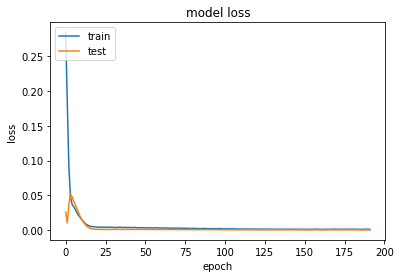

In [51]:
#loss visualization in training and validation
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()  

Visualize results

In [52]:
#convert string to datetime

def to_datetime(test_date):
  test_datetime = []
  for i in range(len(test_date)):
    date = datetime.datetime.strptime(test_date[i], "%Y.%m.%d")
    test_datetime.append(date)
  return test_datetime

test_datetime = to_datetime(test_date)

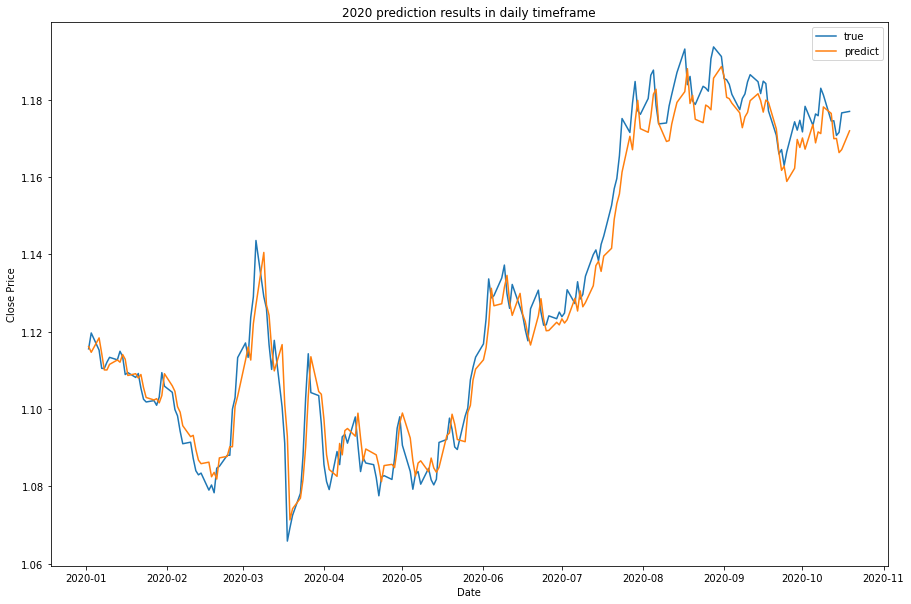

In [53]:
#visualize data

plt.figure(figsize=[15,10])
plt.title('2020 prediction results in daily timeframe')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.plot(test_datetime, testY)
plt.plot(test_datetime, predictedTest)
plt.legend(['true', 'predict'], loc='upper right')
plt.show()